In [1]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

from datetime import date, datetime, timedelta
import time

import matplotlib.pyplot as plt

t0 = time.time()

# Read recipe inputs
NAFCUSTOMER_REVENUE_AGGREGATED = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED")
NAFCUSTOMER_REVENUE_AGGREGATED_df = NAFCUSTOMER_REVENUE_AGGREGATED.get_dataframe()

NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT = dataiku.Dataset("NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT")
NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df = NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT.get_dataframe()

t1 = time.time()
print("load duration", (t1-t0)/60.0, "minutes")


load duration 10.337808760007222 minutes


In [2]:
# create a copy of the input datasets
# this leaves the original dataset in memory and allows for a quick reload without having to back to Snowflake

print(len(NAFCUSTOMER_REVENUE_AGGREGATED_df), "rows in NAFCUSTOMER_REVENUE_AGGREGATED")
df = NAFCUSTOMER_REVENUE_AGGREGATED_df.copy()

print(len(NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df), "rows in NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT")
df_a = NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df

18075044 rows in NAFCUSTOMER_REVENUE_AGGREGATED
2319568 rows in NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT


In [3]:
# Prep data
#
# cast year to integer and create a revenue date column using month and year
#

df['CUSTOMER_ID'] = df['CUSTOMER_ID'].astype('Int64')
df['SETUP_DATE_DT'] = pd.to_datetime(df['SETUP_DATE'])
df['SETUP_YEAR'] = df.SETUP_DATE_DT.dt.year

df['REVENUE_YEAR'] = df['REVENUE_YEAR'].astype('Int64')
df['REVENUE_DATE'] = df['REVENUE_MONTH'].astype(str) + '-' + df['REVENUE_YEAR'].astype(str)
df['REVENUE_DATE'] = pd.to_datetime(df['REVENUE_DATE'], format='%m-%Y').dt.strftime('%m-%Y')

#
# filter out Jan 2023 as it represents only a partial year
#

print(len(df), "before filter")
df = df[df.REVENUE_YEAR!=2023]
print(len(df), "after filter, removing 2023")

# break down of revenue_year
df.REVENUE_YEAR.value_counts()

18075044 before filter
17673397 after filter, removing 2023


2022    4836440
2021    4517640
2020    4243565
2019    4075752
Name: REVENUE_YEAR, dtype: Int64

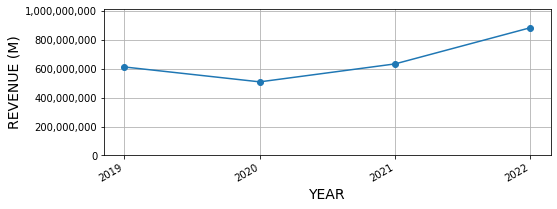

,REVENUE_YEAR,REVENUE_AMOUNT_USD
0,2019,6.118864e+08
1,2020,5.089365e+08
2,2021,6.331536e+08
3,2022,8.832951e+08


In [7]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

# plot out sum of revenue per year
# in order to do a quick reonciliation against 

# aggregate revenue at annual grain
df_revenue_per_year = df.groupby(['REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()
df_revenue_per_year.REVENUE_AMOUNT_USD = df_revenue_per_year.REVENUE_AMOUNT_USD
df_revenue_per_year.head()

max_revenue = df_revenue_per_year.REVENUE_AMOUNT_USD.max()

chart_revenue_year = [] 
for y in df_revenue_per_year.REVENUE_YEAR.tolist():
    chart_revenue_year.append(str(y))
    
fig, ax1 = plt.subplots(figsize=(8,3))
ax1.plot(chart_revenue_year,df_revenue_per_year['REVENUE_AMOUNT_USD'], marker='o')
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('REVENUE (M)', fontsize=14)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.grid()
ax1.set_ylim(ymin=0, ymax=max_revenue*1.15)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
fig.autofmt_xdate()
plt.show()

df_revenue_per_year.head()

In [34]:
df_revenue_by_customer_and_year = df.groupby(['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()
print(len(df_revenue_by_customer_and_year))

df_spend_by_customer_and_year = df.groupby(['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR']).GROSS_SPEND_AMOUNT.sum().reset_index()
print(len(df_spend_by_customer_and_year))

df_active_card_count_by_customer = df_a.groupby(['CUSTOMER_ID','CUSTOMER','YEAR_NUMBER']).ACTIVE_CARD_COUNT.sum().reset_index()
df_active_card_count_by_customer.columns = ['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR','ACTIVE_CARD_COUNT']
print(len(df_active_card_count_by_customer))

df_customer_setup_year = df.groupby(['CUSTOMER_ID','CUSTOMER']).SETUP_YEAR.min().reset_index()
print(len(df_customer_setup_year))

df_customer_fleet_size = df_active_card_count_by_customer.groupby(['CUSTOMER_ID','CUSTOMER']).ACTIVE_CARD_COUNT.max().reset_index()
df_customer_fleet_size.columns = ['CUSTOMER_ID', 'CUSTOMER', 'FLEET_SIZE']

df_customer_fleet_size['FLEET_SIZE_CATEGORY'] = 'NOT SET'
df_customer_fleet_size.loc[df_customer_fleet_size.FLEET_SIZE<=0, 'FLEET_SIZE_CATEGORY'] = 'zero cards'
for i in range(1,21):
    df_customer_fleet_size.loc[df_customer_fleet_size.FLEET_SIZE==i, 'FLEET_SIZE_CATEGORY'] = str(i) + ' card(s)'
df_customer_fleet_size.loc[df_customer_fleet_size.FLEET_SIZE>20, 'FLEET_SIZE_CATEGORY'] = '> 20 cards'
print(len(df_customer_fleet_size))

1777729
1777729
1771976
650886
649448


In [35]:
print(len(df_revenue_by_customer_and_year))
df_j = pd.merge(df_revenue_by_customer_and_year,df_spend_by_customer_and_year,how='left',on=['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR'])
print(len(df_j))

df_j = pd.merge(df_j,df_active_card_count_by_customer,how='left',on=['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR'])
print(len(df_j))

df_j = pd.merge(df_j,df_customer_fleet_size, how='left',on=['CUSTOMER_ID','CUSTOMER'])
print(len(df_j))

df_j = pd.merge(df_j, df_customer_setup_year, how='left', on=['CUSTOMER_ID','CUSTOMER'])
print(len(df_j))

df_j.head()

1777729
1777729
1777729
1777729
1777729


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,ACTIVE_CARD_COUNT,FLEET_SIZE,FLEET_SIZE_CATEGORY,SETUP_YEAR
0,77000000,1 AUTO PARTS INC,2019,175.47,0.00,1.0,1.0,1 card(s),2012
1,77000001,94775 J AND J SNACK FOODS AA,2022,74.15,3318.62,3.0,3.0,3 card(s),2022
2,77000002,APOSTROPHE DESIGN INC,2019,177.47,8944.23,4.0,8.0,8 card(s),2018
3,77000002,APOSTROPHE DESIGN INC,2020,271.60,10358.34,4.0,8.0,8 card(s),2018
4,77000002,APOSTROPHE DESIGN INC,2021,243.51,13094.44,8.0,8.0,8 card(s),2018


In [42]:
df_j.FLEET_SIZE_CATEGORY.unique()

array(['1 card(s)', '3 card(s)', '8 card(s)', '> 20 cards', '7 card(s)',
       '19 card(s)', '4 card(s)', '15 card(s)', '2 card(s)', '12 card(s)',
       '6 card(s)', '16 card(s)', '20 card(s)', '13 card(s)',
       '14 card(s)', '5 card(s)', '11 card(s)', '17 card(s)',
       '18 card(s)', '9 card(s)', '10 card(s)', nan], dtype=object)

1777729
1776264
----
Observed Average Retention Rate (2019-2022): 90.5 %
[0.8833307663534952, 0.905334213443264, 0.925627992076157]


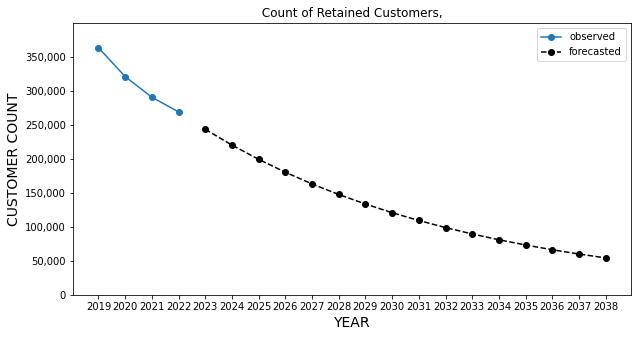

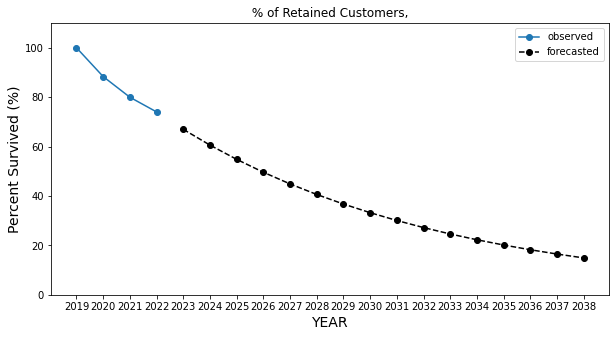

forecast period: 15
AVG Tenure (Observed + Forecasted): 7.87 Years
check_sum: 1.0


In [37]:
df_activity = df_j.copy()
print(len(df_activity))
df_activity = df_activity[~df_activity.FLEET_SIZE_CATEGORY.isnull()]
print(len(df_activity))

df_sub = df_activity[df_activity.SETUP_YEAR<2019]

_fleet_size = []
_observed_avg_retention_rate = []
_expected_tenure = []
_revenue_year = []
_observed_customer_count = []
_observed_customer_percent = []
_chart_forecast_year = []
_chart_forecast_from_first = []

groups =  ['1 card(s)', '2 card(s)', '3 card(s)', '4 card(s)', '5 card(s)', '6 card(s)', 
           '7 card(s)','8 card(s)','9 card(s)','10 card(s)',  '11 card(s)',
           '12 card(s)','13 card(s)','14 card(s)', '15 card(s)','16 card(s)','17 card(s)'
           ,'18 card(s)','19 card(s)','20 card(s)','> 20 cards']



    df_sub = df_sub.groupby(['REVENUE_YEAR']).CUSTOMER_ID.nunique().reset_index()
    df_sub.columns = ['REVENUE_YEAR','CUSTOMER_COUNT']
    df_sub.REVENUE_YEAR = df_sub.REVENUE_YEAR.astype(str)
    df_sub.CUSTOMER_COUNT = df_sub.CUSTOMER_COUNT.astype('Int64')

    df_sub['SURVIVED_FROM_FIRST'] = (df_sub.CUSTOMER_COUNT / df_sub.iloc[0].CUSTOMER_COUNT)
    df_sub['SURVIVED_FROM_FIRST_PERCENT'] = (df_sub.CUSTOMER_COUNT / df_sub.iloc[0].CUSTOMER_COUNT)*100
    df_sub['CUSTOMERS_LEFT'] = 0

    row_count = len(df_sub)

    row_index = 0
    retention_observations = []
    observed_retentions = 0
    for i in range(row_count):
        if i>0:
            survived = df_sub.iloc[i].CUSTOMER_COUNT / df_sub.iloc[i-1].CUSTOMER_COUNT
            df_sub.loc[i,'SURVIVED_FROM_PREV'] = survived
            df_sub.loc[i,'CUSTOMERS_LEFT'] = df_sub.iloc[i-1].CUSTOMER_COUNT - df_sub.iloc[i].CUSTOMER_COUNT
            retention_observations.append(survived)
        row_index+=1

    avg_retention_rate = sum(retention_observations)/len(retention_observations)                
    print("----")
    print("Observed Average Retention Rate (2019-2022):", 100*round(avg_retention_rate,3), "%")
    print(retention_observations)
    len(retention_observations)                

    forecast_year = 2022

    df_sub['FORECAST_CUSTOMER_COUNT'] = np.nan
    df_sub['FORECAST_FROM_FIRST_PERCENT'] = np.nan

    forecast_years = 15

    for i in range(forecast_years+1):

        forecast_year += 1
        if i==0:
            forecast_customer_count = round(avg_retention_rate * df_sub.iloc[i+row_count-1].CUSTOMER_COUNT,0)
            customers_left = df_sub.iloc[i+row_count-1].CUSTOMER_COUNT - forecast_customer_count
        else:
            forecast_customer_count = round(avg_retention_rate * df_sub.iloc[i+row_count-1].FORECAST_CUSTOMER_COUNT,0)
            customers_left = df_sub.iloc[i+row_count-1].FORECAST_CUSTOMER_COUNT - forecast_customer_count

        forecast_from_first_percent = (forecast_customer_count/df_sub.iloc[0].CUSTOMER_COUNT)*100

        dict = {'REVENUE_YEAR':forecast_year,'CUSTOMERS_LEFT': customers_left, 'SURVIVED_FROM_PREV': avg_retention_rate, 'FORECAST_CUSTOMER_COUNT':forecast_customer_count,'FORECAST_FROM_FIRST_PERCENT':forecast_from_first_percent}
        df_sub = df_sub.append(dict, ignore_index = True)


    df_sub['CUSTOMERS_LEFT_PERCENT'] = df_sub['CUSTOMERS_LEFT'] / df_sub.iloc[0].CUSTOMER_COUNT
    df_sub.FORECAST_CUSTOMER_COUNT = df_sub.FORECAST_CUSTOMER_COUNT.astype('Int64') 

    chart_revenue_year = df_sub.REVENUE_YEAR[0:row_index].tolist()
    chart_customer_count = df_sub.CUSTOMER_COUNT[0:row_index].tolist()

    chart_survived_from_first = df_sub.SURVIVED_FROM_FIRST_PERCENT[0:row_index].tolist()

    l = []
    max_i = 0
    for i in df_sub.REVENUE_YEAR[row_index:].tolist():
        l.append(str(int(i)))
        max_i = i

    chart_forecast_year = l
    chart_forecast_customer_count = df_sub.FORECAST_CUSTOMER_COUNT[row_index:].tolist()
    chart_forecast_from_first = df_sub.FORECAST_FROM_FIRST_PERCENT[row_index:].tolist()

    max_y = df_sub.CUSTOMER_COUNT.max()
    max_y = max_y + max_y*0.1

    #_revenue_year.append(chart_revenue_year)
    #_observed_customer_count.append(chart_customer_count)    

    fig, ax1 = plt.subplots(figsize=(10,5))
    plt.plot(chart_revenue_year,chart_customer_count, marker='o', c='C0')
    plt.plot(chart_forecast_year,chart_forecast_customer_count, marker='o', c='black', linestyle='dashed')
    ax1.set_ylim(ymin=0, ymax=max_y)
    ax1.set_xlabel('YEAR', fontsize=14)
    #ax1.set_xlim(xmin=2019, xmax=2023+forecast_years)
    ax1.set_ylabel('CUSTOMER COUNT', fontsize=14)
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    #plt.title(' Count of Retained Customers, ' + granular_filter_group)
    plt.title(' Count of Retained Customers, ')
    plt.legend(['observed','forecasted'])

    #_observed_customer_percent.append(chart_survived_from_first)
    #_chart_forecast_year.append(chart_forecast_year)
    #_chart_forecast_from_first.append(chart_survived_from_first)

    fig, ax2 = plt.subplots(figsize=(10,5))
    plt.plot(chart_revenue_year,chart_survived_from_first, marker='o', c='C0')
    plt.plot(chart_forecast_year,chart_forecast_from_first, marker='o', c='black', linestyle='dashed')
    ax2.set_ylim(ymin=0, ymax=110)
    ax2.set_xlabel('YEAR', fontsize=14)
    ax2.set_ylabel('Percent Survived (%)', fontsize=14)
    #plt.title(' % of Retained Customers, ' + granular_filter_group)
    plt.title(' % of Retained Customers, ')
    plt.legend(['observed','forecasted'])
    #plt.subplots_adjust(left=2.0,right=3.0)
    plt.show()

    fraction_remaining = 1
    avg_tenure = 0
    check_sum = 0
    for i in range(forecast_years):

        avg_tenure += df_sub.iloc[i].CUSTOMERS_LEFT_PERCENT * i

        fraction_remaining -=  df_sub.iloc[i].CUSTOMERS_LEFT_PERCENT
        check_sum += df_sub.iloc[i].CUSTOMERS_LEFT_PERCENT

    check_sum += fraction_remaining

    avg_tenure += fraction_remaining * i
    print("forecast period:", forecast_years)
    print("AVG Tenure (Observed + Forecasted):", round(avg_tenure,2), "Years")
    print("check_sum:", round(check_sum,2))

In [0]:
# Compute recipe outputs
# TODO: Write here your actual code that computes the outputs
# NB: DSS supports several kinds of APIs for reading and writing data. Please see doc.

#TENURE_df = ... # Compute a Pandas dataframe to write into TENURE


# Write recipe outputs
#TENURE = dataiku.Dataset("TENURE")
#TENURE.write_with_schema(TENURE_df)